# Data source selection

In [146]:
# !pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install
# !pip install jupyterthemes
# !jt -N -T -f firacode -tf loraserif -nf latosans -fs 100 -tfs 10 -nfs 115 -cellw 95% -t chesterish

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_columns", None)
# pd.set_option("max_rows", None)`

### Main sector and public companies in Canada


In [147]:
# !pip install plotly_express==0.4.0
import plotly.express as px

df_companies = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Business_Analysis\yahoo_finance_companies.xlsx',index_col=0)
df_companies = df_companies.drop_duplicates(subset =['longName'], keep = 'first')

df_companies['sector'] = df_companies['sector'].fillna('Others')
df_companies['state'] = df_companies['state'].fillna('Others')
df_companies['industry'] = df_companies['industry'].fillna('Others')
df_companies['totalRevenue'] = df_companies['totalRevenue'].fillna(0)
df_companies['totalRevenue'] = df_companies['totalRevenue'].astype(float)

#Segmetation
df_companies = df_companies[(df_companies['country'] == 'Canada')]
df_companies = df_companies[(df_companies['totalRevenue'] !=0) ]

fig = px.treemap(df_companies,
                 path=['sector','industry'],
                 values='totalRevenue',
                 color='totalRevenue',
                 color_continuous_scale='Viridis',
                )

fig.update_layout(width=1400, height=700,)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update_layout(template='plotly_dark', title="Industries of Canada")

fig.show()

### Apliying Pareto rule to select the most important companies in Canada

In [148]:
import pandas as pd
import plotly.express as px

df_companies = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Business_Analysis\yahoo_finance_companies.xlsx',index_col=0)
df_companies = df_companies.drop_duplicates(subset =['longName'], keep = 'first')

df0 = df_companies.copy();
df0['totalRevenue'] = df0['totalRevenue'].fillna(0)
df0['totalRevenue'] = df0['totalRevenue'].astype(float)
df0 = df0[(df0['totalRevenue'] > 0) ]

df0 = df0[(df0['country'] == 'Canada')]


df0["p1"] = df0["totalRevenue"] / df0.groupby('sector')["totalRevenue"].transform('sum')
df0 = df0.groupby(['sector','industry', 'longName', 'p1'])["totalRevenue"].agg(['sum'])
df0 = df0.sort_values(by=['sector','p1'], ascending=False)
df0.reset_index(drop=False, inplace=True)
df0["p2"] = df0.groupby('sector')["p1"].transform('cumsum')


df0 = df0.sort_values(by=['sum'], ascending=False)
df0['q1'] = df0['sum'] / df0['sum'].sum()
df0['q2'] = df0['q1'].cumsum()


def pareto_principle(row):
    if row['p2'] <= 0.80 : clasifico = 0
    else: clasifico = 1
    return clasifico
df0['pareto1'] = df0.apply(pareto_principle, axis=1)

def pareto_principle(row):
    if row['q2'] <= 0.80 : clasifico = 0
    else: clasifico = 1
    return clasifico
df0['pareto2'] = df0.apply(pareto_principle, axis=1)

df0['pareto'] = df0['pareto1'] * df0['pareto2']

def main_participants(row):
    if row['pareto'] == 0 : clasifico = row['longName']
    else: clasifico = 'other'
    return clasifico
df0['name'] = df0.apply(main_participants, axis=1)

def main_participants(row):
    if row['pareto'] == 0 : clasifico = 'main'
    else: clasifico = 'other'
    return clasifico
df0['pareto'] = df0.apply(main_participants, axis=1)

df0.drop(df0.columns[0:2], inplace=True, axis=1)
# df0.drop(df0.columns[2:3], inplace=True, axis=1)

df_companies = pd.merge(df_companies,df0,left_on='longName',right_on='longName')

display(df0)


,longName,p1,sum,p2,q1,q2,pareto1,pareto2,pareto,name
602,Brookfield Asset Management Inc.,0.16,"88,874,999,808.00",0.16,0.05,0.05,0,0,main,Brookfield Asset Management Inc.
603,Power Corporation of Canada,0.12,"67,407,998,976.00",0.28,0.03,0.08,0,0,main,Power Corporation of Canada
934,Alimentation Couche-Tard Inc.,0.32,"62,809,899,008.00",0.32,0.03,0.11,0,0,main,Alimentation Couche-Tard Inc.
723,Cenovus Energy Inc.,0.16,"61,789,999,104.00",0.16,0.03,0.15,0,0,main,Cenovus Energy Inc.
604,Power Financial Corporation,0.10,"57,470,001,152.00",0.38,0.03,0.17,0,0,main,Power Financial Corporation
...,...,...,...,...,...,...,...,...,...,...
190,iSIGN Media Solutions Inc.,0.00,119.00,1.00,0.00,1.00,1,1,other,other
191,Blockchain Venture Capital Inc.,0.00,77.00,1.00,0.00,1.00,1,1,other,other
393,Aduro Clean Technologies Inc.,0.00,47.00,1.00,0.00,1.00,1,1,other,other
1299,Wescan Goldfields Inc.,0.00,42.00,1.00,0.00,1.00,1,1,other,other


### Concentration of public companies by sector

In [149]:

df0 = df_companies.copy();
df0 = df0[(df0['country'] == 'Canada')]
df0 = df0.groupby(['sector', 'pareto'])["totalRevenue"].agg(['sum','count']).unstack()

df0.columns = ["_".join(x) for x in df0.columns.ravel()]
df0 = df0.fillna(0)


df0['sum_total'] = df0['sum_main']+df0['sum_other']
df0['count_total'] = df0['count_main']+df0['count_other']

df0 = df0.sort_values(by='sum_total', ascending=False)
df0['share'] = df0['sum_total']/df0['sum_total'].sum()
df0['cum_share'] = df0['share'].cumsum()
display(df0)


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_bar(x=df0.index, y=df0['sum_main'], name="Big companies",secondary_y=False, text=df0['count_main'], )
fig.add_bar(x=df0.index, y=df0['sum_other'], name="Other companies",secondary_y=False, text=df0['count_other'], )
fig.update_traces(textposition='inside')

fig.add_trace(go.Scatter(x=df0.index, y=df0['cum_share'], name="Cumulated share"), secondary_y=True,)  


# Add figure title
fig.update_layout(title_text="Double Y Axis Example")
fig.update_layout(barmode='stack')


# Set x-axis title
fig.update_xaxes(title_text="Sectors")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Total revenue</b> (CAD)", secondary_y=False)
fig.update_yaxes(title_text="<b>Cumulated share</b> (%)", secondary_y=True)


fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

large_title_format = 'Total revenue and number of companies by sector'
small_title_format = "<span style='font-size:13px; font-family:Tahoma'>Main companies vs other companies by total revenue."

fig.update_layout(title=large_title_format + "<br>" + small_title_format,
                  height=600,
#                   margin=dict(t=130, b=0, l=70, r=40),
                  hovermode="x unified", 
                  # xaxis_title=' ', yaxis_title=" ",
#                   plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  template='plotly_dark',
#                   legend=dict(orientation="h", yanchor="bottom", y=1.2, xanchor="left", x=0.45),template='plotly_dark',
                 )
# Set x-axis title
fig.update_xaxes(title_text=" ")

fig.show()

C:\Users\Admin\AppData\Local\Temp/ipykernel_15852/517154216.py:5: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



,sum_main,sum_other,count_main,count_other,sum_total,count_total,share,cum_share
sector,,,,,,,,
Financial Services,"532,860,598,272.00","27,583,679,732.00",14,107,"560,444,278,004.00",121,0.29,0.29
Energy,"327,369,163,776.00","48,469,643,580.00",12,130,"375,838,807,356.00",142,0.19,0.48
Basic Materials,"160,044,061,056.00","41,193,138,139.00",31,186,"201,237,199,195.00",217,0.10,0.59
Consumer Defensive,"183,179,623,424.00","15,781,486,052.00",7,62,"198,961,109,476.00",69,0.10,0.69
Consumer Cyclical,"154,529,673,728.00","41,792,187,788.00",9,75,"196,321,861,516.00",84,0.10,0.79
Industrials,"125,833,634,816.00","32,150,566,634.00",18,113,"157,984,201,450.00",131,0.08,0.87
Communication Services,"61,632,000,000.00","17,649,556,981.00",4,61,"79,281,556,981.00",65,0.04,0.91
Utilities,"48,269,499,648.00","15,189,999,109.00",7,21,"63,459,498,757.00",28,0.03,0.95
Technology,"40,298,703,360.00","10,597,814,149.00",10,155,"50,896,517,509.00",165,0.03,0.97


### Energy sector: Selection and analysis of the main companies
----
For analysis, I selected the Canadian energy sector to analyze the impact and benefits of Russia's potential exclusion from global energy markets. To select the main public companies in the Canadian energy sector, I used the Investopedia article as a reference https://www.investopedia.com/investing/canadian-oil-companies/, but the list is not updated. So I used Yahoo Finance to get the most recent data. However, is important to mention the Investopedia article uses market capitalization, which could have changed since July 2020. For that reason, I selected another variable more stable like total revenue.

In [150]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_columns", None)
# pd.set_option("max_rows", None)`

df0 = df_companies.copy();
df0 = df0[(df0['country'] == 'Canada')]
df0 = df0[(df0['sector'] == 'Energy')]
df0 = df0[(df0['pareto'] == 'main')]
df0 = df0.groupby(['sector','industry', 'Symbol', 'name'])["totalRevenue"].agg(['sum'])

# reset_index to make the groupby columns into normal columns
df0 = df0.reset_index()
# sort dataframe by the column you want
df0.sort_values(by='sum', ascending=False, inplace=True)
# df0 = df0.sort_values(by='sum', ascending=False)
display(df0)

# plot df0 with plotly express
import plotly.express as px
fig = px.bar(df0, x=df0['name'], y='sum', text='sum', color = 'industry', color_discrete_sequence=px.colors.qualitative.Dark24)
  
  
  
  

#set dark theme
fig.update_layout(template='plotly_dark')

# get format labels
fig.update_yaxes(tickprefix="$", ticksuffix="M")

#get format labels bars
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')

#disabling lines between bars and grid
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.update_layout(title=large_title_format + "<br>" + small_title_format,
                  height=600,
                  margin=dict(t=130, b=0, l=70, r=40),
                  hovermode="x unified", 
                  xaxis_title=' ', yaxis_title=" ",
#                   plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  template='plotly_dark',
#                   legend=dict(orientation="h", yanchor="bottom", y=1.2, xanchor="left", x=0.45),template='plotly_dark',
                 )

# set the title
fig.update_layout(title_text='Main companies by total revenue')

# show the plot
fig.show()


,sector,industry,Symbol,name,sum
3,Energy,Oil & Gas Integrated,CVE.TO,Cenovus Energy Inc.,"61,789,999,104.00"
4,Energy,Oil & Gas Integrated,IMO.TO,Imperial Oil Limited,"52,456,001,536.00"
6,Energy,Oil & Gas Midstream,ENB.TO,Enbridge Inc.,"52,297,998,336.00"
5,Energy,Oil & Gas Integrated,SU.TO,Suncor Energy Inc.,"43,939,999,744.00"
1,Energy,Oil & Gas E&P,CNQ.TO,Canadian Natural Resources Limited,"39,075,999,744.00"
11,Energy,Oil & Gas Refining & Marketing,PKI.TO,Parkland Corporation,"24,847,998,976.00"
10,Energy,Oil & Gas Midstream,TRP-PF.TO,TC Energy Corporation,"13,960,999,936.00"
9,Energy,Oil & Gas Midstream,PPL-PO.TO,Pembina Pipeline Corporation,"9,649,000,448.00"
7,Energy,Oil & Gas Midstream,GEI.TO,Gibson Energy Inc.,"8,289,867,776.00"
0,Energy,Oil & Gas E&P,ARX.TO,ARC Resources Ltd.,"7,738,299,904.00"


### Energy Sector: Impact of Commodities on Integrated Companies
----
The goal is to assess how fluctuations in input and product prices affect companies in the energy sector. To streamline the analysis, we have chosen companies with vertical integration, meaning firms that perform the processes of exploration, extraction, transportation, storage, refining, and distribution without relying on third parties. Instead of utilizing multiple companies for each stage of the process, this approach provides a more consolidated perspective.

In [151]:
# !pip install plotly_express==0.4.0
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_columns", None)

df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();
df0 = df0.fillna(method="bfill")
df0 = df0.fillna(method="ffill")

HPR = (df_daily_quote.pct_change()+1).cumprod()-1

# Plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(rows=1, cols=1,
                    specs=[
                           [{"secondary_y": True}], 
                          #  [{"secondary_y": True}],
#                            [{"secondary_y": True}],
#                            [{"secondary_y": True}],
                          ],                 
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                   )


fig.add_trace(go.Scatter(x=HPR.index, y=HPR['BZ=F'], name="Brent Oil",stackgroup='one' ),row=1, col=1, secondary_y=False,)

fig.add_trace(go.Scatter(x=HPR.index, y=HPR['SU.TO'], name="Suncor Energy Inc.",),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['CVE.TO'], name="Cenovus Energy Inc.",),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['IMO.TO'], name="Imperial Oil Limited",),row=1, col=1, secondary_y=False,)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")


fig.add_annotation( # add a text callout with arrow
    text="Brent Oil", x='2022-05-01', y=0.5, arrowhead=3, showarrow=False
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# template =["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig.update_layout(template='plotly_dark',
                  title="Crude Oil, Gasoline, Heating Oil & Main integrated companies",
                  title_font_size=20,
                  legend_title_text='Financials')

large_title_format = 'Canadian Oil industries'
small_title_format = "<span style='font-size:13px; font-family:Tahoma'>Crude Oil, Gasoline, Heating Oil & Main integrated companies."

fig.update_layout(title=large_title_format + "<br>" + small_title_format,
                  height=800,
                  margin=dict(t=130, b=0, l=70, r=40),
                  hovermode="x unified", 
                  xaxis_title=' ', yaxis_title=" ",
                  # plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  # legend=dict(orientation="h", yanchor="bottom", y=1.2, xanchor="left", x=0.45)
                 )

# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Prices in percentage change</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>Cumulated share</b> (%)", secondary_y=True)


fig.show()

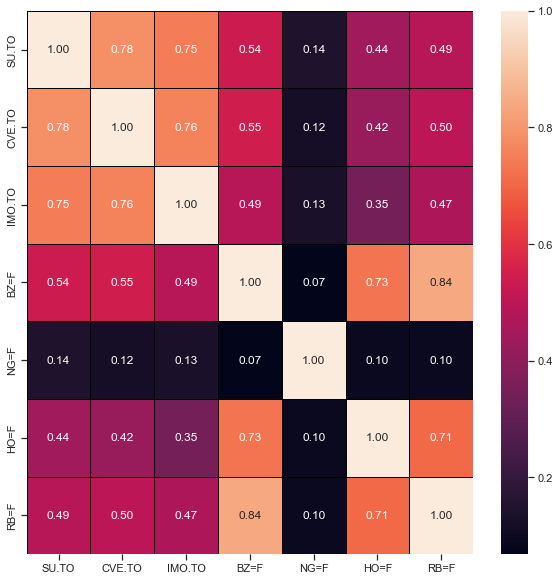

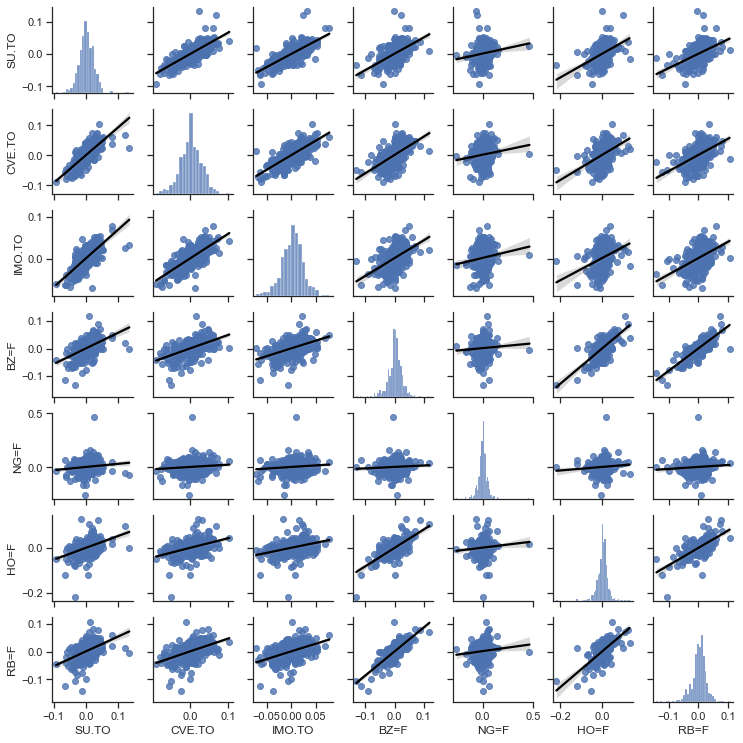

In [153]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_columns", None)

df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();
df0 = df0.fillna(method="bfill")
df0 = df0.fillna(method="ffill")

HPR = (df_daily_quote.pct_change()+1).cumprod()-1

# Plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(rows=3, cols=3,
                    specs=[
                           [{"secondary_y": True} , {"secondary_y": True} , {"secondary_y": True}],
                           [{"secondary_y": True} , {"secondary_y": True} , {"secondary_y": True}],
                           [{"secondary_y": True} , {"secondary_y": True} , {"secondary_y": True}],
                          ],                 
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                   )

# Add traces
# fig = px.area(df0, x=HPR.index, y=HPR['CL=F'],)
fig.add_trace(go.Scatter(x=df0.index, y=df0['NG=F'], name="Natural Gas Futures",),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=df0.index, y=df0['HO=F'], name="Heating Oil Futures"),row=1, col=2, secondary_y=False,)
fig.add_trace(go.Scatter(x=df0.index, y=df0['RB=F'], name="RBOB Gasoline Futures"),row=1, col=3, secondary_y=False,)

fig.add_trace(go.Scatter(x=df0.index, y=df0['NG=F'].pct_change(), name="Natural Gas Futures",),row=2, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=df0.index, y=df0['HO=F'].pct_change(), name="Heating Oil Futures"),row=2, col=2, secondary_y=False,)
fig.add_trace(go.Scatter(x=df0.index, y=df0['RB=F'].pct_change(), name="RBOB Gasoline Futures"),row=2, col=3, secondary_y=False,)

fig.add_trace(go.Scatter(x=df0.index, y=df0['NG=F'].pct_change().pct_change(), name="Natural Gas Futures",),row=3, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=df0.index, y=df0['HO=F'].pct_change().pct_change(), name="Heating Oil Futures"),row=3, col=2, secondary_y=False,)
fig.add_trace(go.Scatter(x=df0.index, y=df0['RB=F'].pct_change().pct_change(), name="RBOB Gasoline Futures"),row=3, col=3, secondary_y=False,)



# Add figure title
fig.update_layout(title_text="Double Y Axis Example")
fig.update_layout(barmode='stack')


# Set x-axis title
fig.update_xaxes(title_text="")

# # Set y-axes titles
# fig.update_yaxes(title_text="<b>Commodities prices in percentage change</b> (%)", secondary_y=False)
# fig.update_yaxes(title_text="<b>Cumulated share</b> (%)", secondary_y=True)

large_title_format = 'Canadian Oil industries'
small_title_format = "<span style='font-size:13px; font-family:Tahoma'>Crude Oil, Gasoline, Heating Oil & Main integrated companies."

fig.update_layout(title=large_title_format + "<br>" + small_title_format,
                  template='plotly_dark',
                  height=800,
                  margin=dict(t=130, b=0, l=70, r=40),
                  hovermode="x unified", 
                  xaxis_title=' ', yaxis_title=" ",
#                   plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  # legend=dict(orientation="h", yanchor="bottom", y=1.2, xanchor="left", x=0.45)
                  )

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()

#### Stationarity Test: Augmented Dickey–Fuller test (1984)

In [154]:
### ADF test: Augmented Dickey–Fuller test (1984)
#write adfuller_test formula mathematically in latex format
from IPython.display import display, Math, Latex
display(Math(r'H_0: \text{Serie has a unit root}'))
display(Math(r'H_1: \text{Serie has no unit root}'))

# math behind adfuller_tes
display(Math(r'ADF = \frac{\hat{\rho}}{\hat{\sigma}}'))
display(Math(r'\hat{\rho} = \frac{1}{n}\sum_{t=1}^{n}(y_t - y_{t-1})'))
display(Math(r'\hat{\sigma} = \frac{1}{n}\sum_{t=1}^{n}(y_t - y_{t-1})^2'))

df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();

import statsmodels.tsa.stattools as sts

print('Null Hypothesis(H0): Serie has a unit root')

joblist = []
var_list = df0.iloc[:0,:]

for j in var_list:
    result = sts.adfuller(df0[j].pct_change().fillna(method="bfill"))
    s = j
    s0 = result[0]
    s1 = result[1]
    s2 = result[2]
    s3 = result[3]
    s4 = result[4].get('10%')
    s5 = result[5]

    job = {'Variable' : s,
           'ADF Statistic' : s0,
           'p-value': s1,
           'Numbers of lag used' : s2,
           'Numbers of observations': s3,
           'Critical Values': s4,
           'Information Criteria' : s5
          }
    joblist.append(job)
df = pd.DataFrame(joblist)


def adfuller_test(row):
    if row['ADF Statistic'] <= row['Critical Values'] : clasify = 'Null hypothesis rejected'
    else : clasify = 'Non rejected hypothesis'
    return clasify
df['Note'] = df.apply(adfuller_test, axis=1)

# rejected hypothesis

display(df)



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Null Hypothesis(H0): Serie has a unit root


,Variable,ADF Statistic,p-value,Numbers of lag used,Numbers of observations,Critical Values,Information Criteria,Note
0,ARX.TO,-17.59,0.00,0,450,-2.57,"-1,873.18",Null hypothesis rejected
1,BZ=F,-10.71,0.00,5,445,-2.57,"-1,942.78",Null hypothesis rejected
2,CAD=X,-20.02,0.00,0,450,-2.57,"-3,468.80",Null hypothesis rejected
3,CCO.TO,-21.27,0.00,0,450,-2.57,"-1,656.95",Null hypothesis rejected
4,CL=F,-3.83,0.00,16,434,-2.57,"-1,910.23",Null hypothesis rejected
5,CNQ.TO,-18.29,0.00,0,450,-2.57,"-2,102.33",Null hypothesis rejected
6,CVE.TO,-20.43,0.00,0,450,-2.57,"-1,859.65",Null hypothesis rejected
7,ENB.TO,-18.91,0.00,0,450,-2.57,"-2,796.75",Null hypothesis rejected
8,GEI.TO,-20.74,0.00,0,450,-2.57,"-2,344.22",Null hypothesis rejected
9,HO=F,-9.63,0.00,6,444,-2.57,"-1,840.30",Null hypothesis rejected


#### Sector analysis

In [155]:
df_income_statement = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_income_statement.xlsx',index_col=0)
df_balance_Sheet = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_balance_sheet.xlsx',index_col=0)

df_statements = pd.merge(df_balance_Sheet,df_income_statement,left_on='Symbol',right_on='Symbol')
df_statements = pd.merge(df_statements,df_companies[['Symbol','longName','industry']],left_on='Symbol',right_on='Symbol')
# df_statements = df_statements[['Symbol','Total Revenue','Common Stock']]
# df_statements
# # df_statements = df_statements['Total Revenue']

df_list = df_statements.T.iloc[:,0:1]
df_list

,0
Symbol,ENB.TO
Intangible Assets,"4,008,000,000.00"
Capital Surplus,"365,000,000.00"
Total Liab,105496000000
Total Stockholder Equity,53079000000
Minority Interest_x,"2,542,000,000.00"
Deferred Long Term Liab,"1,048,000,000.00"
Other Current Liab,5042000000
Total Assets,168864000000
Common Stock,64799000000


#### Exploring variable relationships : Least Squares Method - Gauss-Márkov (1829)
____

#### Modelling: Least Squares Method - Gauss-Márkov (1829)
___

In [156]:
### Modelling: Least Squares Method - Gauss-Márkov (1829)

df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();

import statsmodels.api as sm

t = df0.index.values
y = df0['RB=F'].pct_change().fillna(method="bfill").values
X = df0['BZ=F'].pct_change().shift(0, axis = 0).fillna(method="bfill").values
# X = sm.add_constant(X)

result=sm.OLS(y,X).fit()
result.summary()

display(result.summary())

HPR = pd.DataFrame({'Endogenous': y, 'resid': result.resid, 'fittedvalues': result.fittedvalues})

# Plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(rows=2, cols=1,
                    specs=[
                           [{"secondary_y": True}], 
                           [{"secondary_y": True}],
#                            [{"secondary_y": True}],
#                            [{"secondary_y": True}],
                          ],                 
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                   )

# Add traces
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['Endogenous'], name="Natural Gas Futures",),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['fittedvalues'], name="RBOB Gasoline Futures"),row=1, col=1, secondary_y=False,)
fig.add_bar(x=HPR.index, y=HPR['resid'], name="resid", row=2, col=1, secondary_y=False)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")
fig.update_layout(barmode='stack')

# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Commodities prices in percentage change</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>Cumulated share</b> (%)", secondary_y=True)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# template =["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig.update_layout(template='plotly_dark',
                  title="Crude Oil, Gasoline, Heating Oil & Natural Gas",
                  height=600,
#                 width=1850,
                 title_font_size=20
                 )

fig.show()
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.706
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              1080.
Date:                Thu, 06 Oct 2022   Prob (F-statistic):                   1.18e-121
Time:                        01:07:37   Log-Likelihood:                          1280.0
No. Observations:                 451   AIC:                                     -2558.
Df Residuals:                     450   BIC:                                     -2554.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8619      0.026     32.863      0.000       0.810       0.913
==============================================================================
Omnibus:                      101.631   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1358.741
Skew:                           0.529   Prob(JB):                    8.98e-296
Kurtosis:                      11.437   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#correlation map
import seaborn as sns
# Visualization of Economy..GDP.per.Capita., Family and Health..Life.Expectancy. 
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df0[['SU.TO','CVE.TO','IMO.TO','BZ=F','NG=F','HO=F','RB=F']].pct_change().corr(), annot=True, linewidths=0.5,linecolor="black", fmt= '.2f',ax=ax)
plt.show()

import seaborn as sns

sns.set(style="ticks", color_codes=True)
sns.pairplot(df0[['SU.TO','CVE.TO','IMO.TO','BZ=F','NG=F','HO=F','RB=F']].pct_change(), kind="reg",plot_kws={'line_kws':{'color':'black'}}, height=1.5 )

In [157]:
### Modelling: Least Squares Method - Gauss-Márkov (1829)

df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.iloc[:,0:15].copy();

import statsmodels.api as sm #Modelos estadistico y metodologías econometricas
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
import pandas as pd

n = df0.columns # five time-series


k = 2 # two exogenous variable

from itertools import combinations
combinations = pd.DataFrame(combinations(n, k))
combinations = combinations.values.tolist()

joblist = []


for j in range(len(combinations)): #numero de modelos que se generan
    t = df0.index.values
    y = df0['BZ=F'].pct_change().fillna(method="bfill").values
    X = df0[combinations[j]].pct_change().fillna(method="bfill").values
    result = sm.OLS(y,X).fit()
    
    s = combinations[j]
    s0 = result.rsquared_adj
    s1 = durbin_watson(result.resid)
    s2 = result.aic
    s3 = result.f_pvalue
    s4 = result.pvalues
# falta el exogeno
    job = {'Exogenous' : s,
           'R^2' : s0,
           'Dw' : s1,
           'AIC' : s2,
           'f_pvalue' : s3,
           'pvalues' : s4,
           
          }
    joblist.append(job)
df = pd.DataFrame(joblist)
display(df)

# Plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(rows=1, cols=1,
                    specs=[
                           [{"secondary_y": True}], 
                          #  [{"secondary_y": True}],
#                            [{"secondary_y": True}],
#                            [{"secondary_y": True}],
                          ],                 
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                   )

# Add traces
fig.add_trace(go.Scatter(x=df['Exogenous'], y=df['R^2'], name="Natural Gas Futures",),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=df['Exogenous'], y=df['AIC'], name="RBOB Gasoline Futures"),row=1, col=1, secondary_y=False,)
# fig.add_bar(x=df.index, y=df['resid'], name="resid", row=2, col=1, secondary_y=False)



# Add figure title
fig.update_layout(title_text="Double Y Axis Example")
fig.update_layout(barmode='stack')


# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Commodities prices in percentage change</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>Cumulated share</b> (%)", secondary_y=True)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# template =["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig.update_layout(template='plotly_dark',
                  title="Crude Oil, Gasoline, Heating Oil & Natural Gas",
                  height=600,
#                 width=1850,
                 title_font_size=20
                 )

fig.show()

#drop row using a filter condition on a column value 
df = df[df['R^2'] != 1 ]
df
    

,Exogenous,R^2,Dw,AIC,f_pvalue,pvalues
0,"[ARX.TO, BZ=F]",1.00,1.88,"-33,847.63",0.00,"[2.2010762145024984e-12, 0.0]"
1,"[ARX.TO, CAD=X]",0.25,2.11,"-2,159.45",0.00,"[2.4840697665429708e-30, 0.6902008386075704]"
2,"[ARX.TO, CCO.TO]",0.25,2.10,"-2,159.89",0.00,"[4.561331155345953e-26, 0.44222745877062375]"
3,"[ARX.TO, CL=F]",0.87,2.43,"-2,939.05",0.00,"[0.7025752629582132, 1.1146723450618602e-170]"
4,"[ARX.TO, CNQ.TO]",0.36,2.10,"-2,233.75",0.00,"[0.0009119712632454417, 7.617785053476556e-18]"
...,...,...,...,...,...,...
100,"[KEY.TO, PKI.TO]",0.20,2.11,"-2,130.57",0.00,"[5.295295847663087e-11, 1.9616683209913147e-05]"
101,"[KEY.TO, PPL.TO]",0.25,2.16,"-2,159.01",0.00,"[0.0011490562473413046, 9.080485074790798e-12]"
102,"[NG=F, PKI.TO]",0.12,2.08,"-2,087.95",0.00,"[0.40884557814297884, 3.2578805542129794e-14]"
103,"[NG=F, PPL.TO]",0.23,2.16,"-2,148.39",0.00,"[0.9526777271765763, 2.0366162979975882e-27]"


,Exogenous,R^2,Dw,AIC,f_pvalue,pvalues
1,"[ARX.TO, CAD=X]",0.25,2.11,"-2,159.45",0.00,"[2.4840697665429708e-30, 0.6902008386075704]"
2,"[ARX.TO, CCO.TO]",0.25,2.10,"-2,159.89",0.00,"[4.561331155345953e-26, 0.44222745877062375]"
3,"[ARX.TO, CL=F]",0.87,2.43,"-2,939.05",0.00,"[0.7025752629582132, 1.1146723450618602e-170]"
4,"[ARX.TO, CNQ.TO]",0.36,2.10,"-2,233.75",0.00,"[0.0009119712632454417, 7.617785053476556e-18]"
5,"[ARX.TO, CVE.TO]",0.36,2.18,"-2,231.10",0.00,"[4.367276226917622e-06, 2.902514828942392e-17]"
...,...,...,...,...,...,...
100,"[KEY.TO, PKI.TO]",0.20,2.11,"-2,130.57",0.00,"[5.295295847663087e-11, 1.9616683209913147e-05]"
101,"[KEY.TO, PPL.TO]",0.25,2.16,"-2,159.01",0.00,"[0.0011490562473413046, 9.080485074790798e-12]"
102,"[NG=F, PKI.TO]",0.12,2.08,"-2,087.95",0.00,"[0.40884557814297884, 3.2578805542129794e-14]"
103,"[NG=F, PPL.TO]",0.23,2.16,"-2,148.39",0.00,"[0.9526777271765763, 2.0366162979975882e-27]"


In [158]:
# send to dataframe to excel file
HPR.to_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\HPR.xlsx')


In [159]:
# generate a combinations of dataframe columns one by one and store it in a list
import matplotlib.pyplot as plt
import pandas as pd


df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();

Q1 = df0["NG=F"].quantile(0.25)


Q3 = df0["NG=F"].quantile(0.75)
IQR = Q3 - Q1
IQR

A = Q1 - 1.5*IQR
B = Q3 + 1.5*IQR

Sin_outliers = df0[(df0["NG=F"] > A) & (df0["NG=F"] < B)]

Sin_outliers['NG=F']
df0['NG=F']
 
x = Sin_outliers['NG=F'] - df0['NG=F']
 
# generate a combinations of dataframe columns one by one and store it in a list
import matplotlib.pyplot as plt
import pandas as pd


df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();

Q1 = df0["NG=F"].quantile(0.25)


Q3 = df0["NG=F"].quantile(0.75)
IQR = Q3 - Q1
IQR

A = Q1 - 1.5*IQR
B = Q3 + 1.5*IQR

Sin_outliers = df0[(df0["NG=F"] > A) & (df0["NG=F"] < B)]

Sin_outliers['NG=F']
df0['NG=F']
 
x = Sin_outliers['NG=F'] - df0['NG=F']
 


In [160]:
# plot a Voronoi diagram of the points in the array `points` 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# generate a combinations of dataframe columns one by one and store it in a list
import matplotlib.pyplot as plt
# import pandas as pd

# https://www.youtube.com/watch?v=bAds9bR4kfA&list=PLUofJx5RUeFrAet3Y_eA0hBeYW50SZ4rZ&index=23

In [161]:
# get the correlation of each combination of columns and store it in a list
def correlation(df, comb):
    corr = []
    for i in comb:
        corr.append(df[list(i)].corr().values[0][1])
    return corr

In [162]:
# df_industries.groupby(["Symbol", "longName"])["totalRevenue"].mean()
# df_industries = df_industries.sort_values(by=df_industries['totalRevenue'], ascending=True) #Ordenamos

In [163]:
# df_companies.dtypes

In [164]:
# get multiples last squeares

In [165]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_columns", None)

df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();
df0 = df0.fillna(method="bfill")
df0 = df0.fillna(method="ffill")

HPR = (df_daily_quote.pct_change()+1).cumprod()-1

HPR['NG=SF']= HPR['NG=F']-HPR['CL=F']
HPR['HO=SF']= HPR['HO=F']-HPR['CL=F']
HPR['RB=SF']= HPR['RB=F']-HPR['CL=F']


# Plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(rows=1, cols=1,
                    specs=[
                           [{"secondary_y": True}], 
#                            [{"secondary_y": True}],
#                            [{"secondary_y": True}],
#                            [{"secondary_y": True}],
                          ],                 
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                   )

# Add traces
fig = px.area(df0, x=HPR.index, y=HPR['CL=F'],)
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['NG=F'], name="Natural Gas Futures",),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['HO=F'], name="Heating Oil Futures"),row=1, col=1, secondary_y=False,)
fig.add_trace(go.Scatter(x=HPR.index, y=HPR['RB=F'], name="RBOB Gasoline Futures"),row=1, col=1, secondary_y=False,)



# Add figure title
fig.update_layout(title_text="Double Y Axis Example")
fig.update_layout(barmode='stack')


# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Commodities prices in percentage change</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>Cumulated share</b> (%)", secondary_y=True)

# fig.add_shape( # add a horizontal "target" line
#     type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#     x0=0, x1=1, xref="paper", y0=200000, y1=200000, yref="y"
# )

fig.add_annotation( # add a text callout with arrow
    text="Brent oil benchmark", x='2022-05-01', y=0.5, arrowhead=3, showarrow=False
)

# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)

# template =["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig.update_layout(template='plotly_dark',
                  title="Crude Oil, Gasoline, Heating Oil & Natural Gas",
                 title_font_size=20)

large_title_format = 'Canadian Oil industries'
small_title_format = "<span style='font-size:13px; font-family:Tahoma'>Crude Oil, Gasoline, Heating Oil & Main integrated companies."

fig.update_layout(title=large_title_format + "<br>" + small_title_format, height=400,
                  margin=dict(t=130, b=0, l=70, r=40),
                  hovermode="x unified", 
                  xaxis_title=' ', yaxis_title=" ",
#                   plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.2, xanchor="left", x=0.45))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [166]:
# https://www.investopedia.com/investing/market-capitalization-defined/
# https://www.investopedia.com/articles/markets/022316/small-cap-vs-mid-cap-vs-large-cap-stocks-2016.asp

In [167]:
# The objective is to identify the main participants of the sector selected, so let's create a table

df_companies = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Business_Analysis\yahoo_finance_companies.xlsx',index_col=0)
df_companies = df_companies.drop_duplicates(subset =['longName'], keep = 'first')
df_companies['sector'] = df_companies['sector'].fillna('Others')
df_companies['industry'] = df_companies['industry'].fillna('Others')
# df_companies['marketCap'] = df_companies['marketCap'].astype(int)

df0 = df_companies.copy();
df0 = df0[(df0['country'] == 'Canada')]

df0 = pd.pivot_table(df0, 
                     values=['totalRevenue'], 
                     index=['longName'], 
#                      columns=['timing'], 
                     aggfunc=['sum'], 
                     fill_value=0, 
                     margins=False, 
                     dropna=True, 
                     margins_name='All', 
                     observed=False)
 
df0.columns = df0.columns.droplevel(1)
df0.rename(columns = {'sum':'value'}, inplace = True)
df0 = df0.sort_values(by='value', ascending=False)
df0.reset_index(drop=False, inplace=True)
# df0.set_index('share',inplace=True)

df0['share'] = df0['value'] / df0['value'].sum()
df0['cu_share'] = df0['share'].cumsum()

def share_company(row):
    if row['cu_share'] <= 0.75 : clasifico = 'main'
    else: clasifico = 'other'
    return clasifico
df0['pareto'] = df0.apply(share_company, axis=1)

def main_participants(row):
    if row['pareto'] == 'main' : clasifico = row['longName']
    else: clasifico = 'others'
    return clasifico
df0['name'] = df0.apply(main_participants, axis=1)

df0.drop(df0.columns[1:4], inplace=True, axis=1)

df_companies = pd.merge(df_companies,df0,left_on='longName',right_on='longName')
df_companies

,Symbol,zip,shortName,longName,currency,country,city,state,industry,address2,address1,website,phone,quoteType,legalType,isEsgPopulated,longBusinessSummary,operatingMargins,industry.1,category,market,sector,fullTimeEmployees,financialCurrency,exchange,numberOfAnalystOpinions,fundFamily,earningsGrowth,payoutRatio,lastDividendValue,sharesOutstanding,marketCap,heldPercentInstitutions,heldPercentInsiders,netIncomeToCommon,totalDebt,bookValue,debtToEquity,beta,grossProfits,grossMargins,ebitda,ebitdaMargins,totalRevenue,revenueGrowth,returnOnEquity,returnOnAssets,profitMargins,pareto,name
0,NTR.TO,S7K 5R6,NUTRIEN LTD,Nutrien Ltd.,CAD,Canada,Saskatoon,SK,Agricultural Inputs,Suite 1700,211 19th Street East,https://www.nutrien.com,NaN,EQUITY,NaN,0.00,Nutrien Ltd. provides crop inputs and services...,0.27,Agricultural Inputs,NaN,ca_market,Basic Materials,"23,500.00",USD,TOR,12.00,NaN,2.36,0.15,0.62,"538,926,016.00","68,508,274,688.00",0.70,0.00,"6,888,999,936.00","11,703,000,064.00",49.10,43.98,0.92,"9,409,000,000.00",0.42,"10,992,000,000.00",0.32,"34,611,998,720.00",0.50,0.28,0.11,0.20,main,Nutrien Ltd.
1,ABX.TO,M5J 2S1,BARRICK GOLD CORPORATION,Barrick Gold Corporation,CAD,Canada,Toronto,ON,Gold,Suite 3700 161 Bay Street Brookfield Place,TD Canada Trust Tower,https://www.barrick.com,NaN,EQUITY,NaN,0.00,Barrick Gold Corporation engages in the explor...,0.35,Gold,NaN,ca_market,Basic Materials,NaN,USD,TOR,16.00,NaN,0.17,0.34,0.26,"1,770,940,032.00","37,260,578,816.00",0.63,0.01,"1,999,000,064.00","5,144,000,000.00",13.62,15.81,0.12,"4,917,000,000.00",0.39,"6,193,999,872.00",0.52,"11,847,999,488.00",-0.01,0.10,0.06,0.17,main,Barrick Gold Corporation
2,FNV.TO,M5L 1G9,FRANCO-NEVADA CORPORATION,Franco-Nevada Corporation,CAD,Canada,Toronto,ON,Gold,Suite 2000 Commerce Court Postal Station PO Bo...,199 Bay Street,https://www.franco-nevada.com,NaN,EQUITY,NaN,0.00,Franco-Nevada Corporation operates as a gold-f...,0.68,Gold,NaN,ca_market,Basic Materials,NaN,USD,TOR,15.00,NaN,0.11,0.31,0.41,"191,556,000.00","32,817,375,232.00",0.72,0.01,"765,400,000.00",0.00,32.51,NaN,0.56,"1,121,700,000.00",0.87,"1,127,399,936.00",0.85,"1,332,899,968.00",0.01,0.13,0.09,0.57,other,others
3,AEM.TO,M5C 2Y7,AGNICO EAGLE MINES LIMITED,Agnico Eagle Mines Limited,CAD,Canada,Toronto,ON,Gold,Suite 400,145 King Street East,https://www.agnicoeagle.com,NaN,EQUITY,NaN,0.00,Agnico Eagle Mines Limited engages in the expl...,0.28,Gold,NaN,ca_market,Basic Materials,"6,810.00",USD,TOR,13.00,NaN,-0.25,0.86,0.51,"455,776,000.00","26,863,437,824.00",0.66,0.00,"586,976,000.00","1,575,686,016.00",35.70,9.68,0.81,"2,095,890,000.00",0.57,"2,279,825,920.00",0.48,"4,796,347,904.00",0.61,0.05,0.05,0.12,other,others
4,TECK-A.TO,V6C 0B3,TECK RESOURCES LIMITED CL A,Teck Resources Limited,CAD,Canada,Vancouver,BC,Other Industrial Metals & Mining,Suite 3300 550 Burrard Street,Bentall 5,https://www.teck.com,NaN,EQUITY,NaN,0.00,Teck Resources Limited engages in exploring fo...,0.47,Other Industrial Metals & Mining,NaN,ca_market,Basic Materials,"13,000.00",CAD,TOR,NaN,NaN,5.40,0.03,0.12,"7,800,000.00","24,748,224,512.00",0.12,0.74,"5,549,000,192.00","9,169,999,872.00",48.04,34.88,1.18,"5,081,000,000.00",0.50,"10,462,999,552.00",0.55,"19,195,000,832.00",1.26,0.24,0.12,0.29,main,Teck Resources Limited
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,AM.V,V6B 6H5,ACADEMY METALS INC,Academy Metals Inc.,CAD,Canada,Vancouver,BC,Gold,Suite 313,515 West Pender Street,https://academymetalsinc.com,NaN,EQUITY,NaN,0.00,"Academy Metals Inc., an exploration stage comp...",0.00,Gold,NaN,ca_market,Basic Materials,NaN,CAD,VAN,NaN,NaN,NaN,0.00,NaN,"1,850,080.00","462,520.00",0.00,0.00,"-176,942.00","1,492,550.00",-0.03,NaN,NaN,NaN,0.00,"56,601.00",0.00,NaN,NaN,NaN,-0.12,0.00,other,others
2648,FWM.CN,V6C 1H2,FlowMetalsCorp,Flow Metals Corp.,CAD,Canada,Vancouver,BC

In [168]:
df0 = df_companies.copy();
# df0 = df0[(df0['country'] == 'Canada') | (df0['country'] == 'United States')]
# df0 = df0[(df0['sector'] == 'Energy')]
# df0 = df0[(df0['pareto'] == 'main')]

df0 = pd.pivot_table(df0, 
                     values=['totalRevenue'], 
                     index=['sector'], 
                     columns=['pareto'], 
                     aggfunc=['sum'], 
                     fill_value=0, 
                     margins=False, 
                     dropna=True, 
                     margins_name='All', 
                     observed=False)

df0.columns = df0.columns.droplevel(1)
# df0.columns = df0.columns.droplevel(1)
# df0.rename(columns = {'sum':'value'}, inplace = True)
# df0 = df0.sort_values(by='All', ascending=False)
df0.reset_index(drop=False, inplace=True)
# df0.rename(columns = {df0.columns[3]:'x'}, inplace = True)
# df0.set_index('share',inplace=True)
# df0 = df0.sort_values(by=df0.iloc[:,3:4], ascending=False)

# 1,643 billones USD (2020)
df0

sector           sum              
pareto                                  main         other
0              Basic Materials   91555898880  109680569666
1       Communication Services   56163999744   23113020694
2            Consumer Cyclical  130722774016   65599087500
3           Consumer Defensive  173090499584   25870566974
4                       Energy  327369163776   48468607567
5           Financial Services  532860598272   25753518225
6                   Healthcare    8192000000   14237408502
7                  Industrials   83488403456   74495797994
8                       Others             0      68697931
9                  Real Estate             0   29767777294
10                  Technology   12627437568   38269079591
11                   Utilities   30291999744   33126877509

In [169]:
# !pip install plotly_express==0.4.0
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=1)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

# fig.add_trace(go.Scatter(x=df0.index, y=df_HPR['NG=F'], name="Natural Gas Sep 22",),secondary_y=True,) 
fig.add_bar(x=df0.index, y=df0['sum'], name="SPY (%)",secondary_y=True)
# fig.add_bar(x=df0.index, y=df0['name'], name="SPY (%)",secondary_y=False)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Benchmark growth rate</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>Holding Period Retun</b> (%)", secondary_y=True)


# template =["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig.update_layout(template='plotly_dark', title="Consumer Cyclical & Multiline Retail")
fig.show()

In [170]:
df0 = df0.groupby(["name"])["share"].sum()
df0 = df0.sort_values(by='share', ascending=False)
df0
# import plotly.express as px

# # df = px.data.gapminder().query("continent == 'Europe' and year == 2007 and pop > 2.e6")
# fig = px.bar(df, y='name', x='share', text_auto='.2s',
#             title="Controlled text sizes, positions and angles")
# fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# fig.show()

KeyError: 'name'

In [ ]:
# df0 = df_companies.copy();
# df0 = df0[(df0['country'] == 'Canada') | (df0['country'] == 'United State')]
# # df0 = df0[(df0['sector'] == 'Energy')]

# df0 = pd.pivot_table(df0, 
#                      values=['totalRevenue'], 
#                      index=['industry','sector'], 
# #                      columns=['sector', 'industry'], 
#                      aggfunc=['count'], 
#                      fill_value=0, 
#                      margins=False, 
#                      dropna=True, 
#                      margins_name='All', 
#                      observed=False)
# df0

,,count
,,totalRevenue
industry,sector,
Advertising Agencies,Communication Services,8
Aerospace & Defense,Industrials,18
Agricultural Inputs,Basic Materials,6
Airlines,Industrials,3
Airports & Air Services,Industrials,1
...,...,...
Utilities—Regulated Electric,Utilities,12
Utilities—Regulated Gas,Utilities,7


In [ ]:
df_statements_x = df_statements.copy()
df_statements_x= df_statements_x[['Symbol','Cash conversion cycle','Day Inventory']]
df_statements_x

,Symbol,Cash conversion cycle,Day Inventory
0,ENB.TO,31.30,21.24
1,TRP.TO,332.13,65.95
2,PPL.TO,28.17,22.37
3,CNQ.TO,24.60,41.07
4,SU.TO,200.55,98.18
5,CVE.TO,41.59,39.65
6,IMO.TO,35.54,20.81
7,TOU.TO,NaN,NaN
8,CCO.TO,174.60,171.73
9,ARX.TO,98.73,4.38


In [ ]:
fig = px.line_polar(df_statements_x, 
                    r="Cash conversion cycle",
                    theta="Day Inventory", 
                    color="Symbol", 
                    line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark")
fig.show()

In [ ]:
fig = px.bar_polar(wind_df, 
                    r="frequency",
                    theta="direction", 
                    color="strength",
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark")
fig.show()

In [ ]:
# !pip install plotly_express==0.4.0
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=1)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_trace(go.Scatter(x=df_HPR.index, y=df_HPR['NG=F'], name="Natural Gas Sep 22",),secondary_y=True,)
fig.add_trace(go.Scatter(x=df_HPR.index, y=df_HPR['HO=F'], name="Heating Oil Sep 22"),secondary_y=True,)
fig.add_trace(go.Scatter(x=df_HPR.index, y=df_HPR['RB=F'], name="RBOB Gasoline Sep 22"),secondary_y=True,)
fig.add_trace(go.Scatter(x=df_HPR.index, y=df_HPR['CL=F'], name="Crude Oil Oct 22"),secondary_y=True,)   

# fig.add_bar(x=data.index, y=data['SPY'], name="SPY (%)",secondary_y=False)

# Add figure title
fig.update_layout(title_text="Double Y Axis Example")

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Benchmark growth rate</b> (%)", secondary_y=False)
fig.update_yaxes(title_text="<b>Holding Period Retun</b> (%)", secondary_y=True)


# template =["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig.update_layout(template='plotly_dark', title="Consumer Cyclical & Multiline Retail")
fig.show()

In [ ]:
## Analisis Pareto-Wicksell

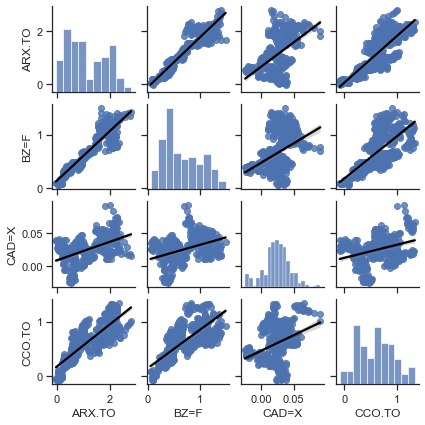

In [ ]:
df_daily_quote = pd.read_excel(r'C:\Users\Admin\Desktop\Planeamiento\0. Resumes\2. Professions\Portfolio\Financial_markets_analysis\yahoo_finance_daily_quotes.xlsx',index_col=0)
df0 = df_daily_quote.copy();
df0 = df0.fillna(method="bfill")
df0 = df0.fillna(method="ffill")

HPR = (df_daily_quote.pct_change()+1).cumprod()-1



import seaborn as sns

sns.set(style="ticks", color_codes=True)
sns.pairplot(HPR.iloc[:,0:4], kind="reg",plot_kws={'line_kws':{'color':'black'}}, height=1.5 )

### asas
----